# <center style='color:blue'>`Eigengap heuristic method` to determine the optimal number of clusters</center>

## 1. Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import laplacian

from sklearn import metrics
from sklearn.cluster import SpectralClustering
from sklearn import datasets

## 2. Create data

In [2]:
X, y = datasets.make_blobs(n_samples=250, centers=6, n_features=2, cluster_std=0.85, random_state=0)

In [3]:
X.shape, y.shape

((250, 2), (250,))

## 3. Spectral clustering 

In [4]:
spec = SpectralClustering(n_clusters=6, assign_labels='discretize', affinity='rbf', random_state=0)
spec.fit(X)
preds = spec.labels_

## 4. Visualize ground truth and spectral clustering results

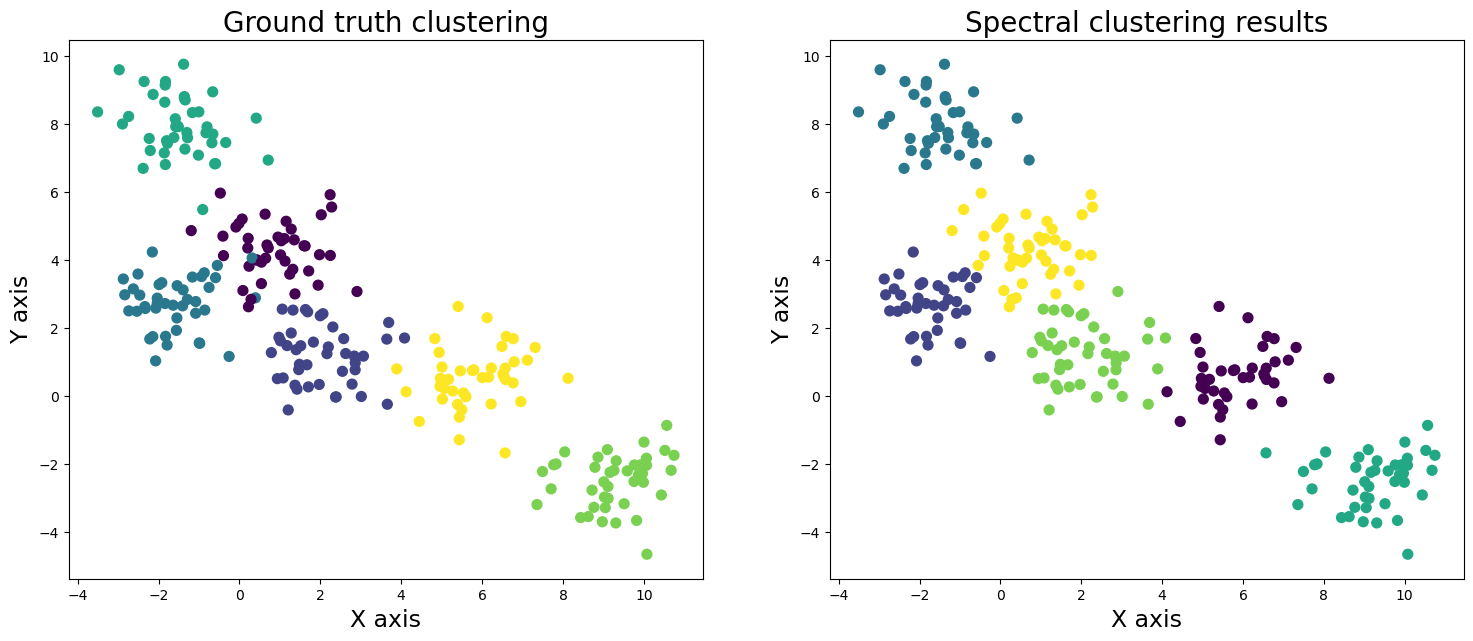

In [6]:
plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], s=50, c=y)
plt.xlabel('X axis', fontsize=17)
plt.ylabel('Y axis', fontsize=17)
plt.title('Ground truth clustering', fontsize=20)

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], s=50, c=preds)
plt.xlabel('X axis', fontsize=17)
plt.ylabel('Y axis', fontsize=17)
plt.title('Spectral clustering results', fontsize=20);

## 5. External validation

In [7]:
print('Rand score:', metrics.rand_score(y, preds))
print('Adjusted Rand score:', metrics.adjusted_rand_score(y, preds))
print('Normalized Mutual Info score:', metrics.normalized_mutual_info_score(y, preds))

Rand score: 0.9816546184738956
Adjusted Rand score: 0.9329595407407482
Normalized Mutual Info score: 0.9334087698523983


## 6. Calculate affinity matrix

In [8]:
def affinity_matrix(ndarray, k):
    dists = squareform(pdist(ndarray))
    
    knn_dists = np.sort(dists, axis=0)[k]
    knn_dists = knn_dists[np.newaxis].T
    
    local_scaling = knn_dists.dot(knn_dists.T)
    
    aff_mat = dists * dists
    aff_mat = -aff_mat / local_scaling
    
    aff_mat[np.where(np.isnan(aff_mat))] = 0.0
    
    aff_mat = np.exp(aff_mat)
    np.fill_diagonal(aff_mat, 0)
    
    return aff_mat

$$
\hat A_{ij} = \exp \left(\frac{-d^2(s_i, s_j)}{\sigma_i\sigma_j}\right)
$$

## 7. Find the optimal number of clusters with eigengap heuristic method

In [9]:
def eigengap_heuristic(A):
    L = laplacian(A, normed=True)
    
    eigenvalues, eigenvectors = np.linalg.eig(L)
    
    plt.figure(figsize=(8, 4))
    plt.plot(np.arange(len(eigenvalues)), eigenvalues, marker='D', color='r')
    plt.xlabel('Index of eigenvalues', fontsize=17)
    plt.ylabel('Eigenvalues', fontsize=17)
    plt.title('Eigengaps between consecutive eigenvalues', fontsize=20)
    
    index_largest_gap = np.argmax(np.diff(eigenvalues))
    n_c = index_largest_gap + 1
    
    return n_c

Optimal number of clusters: 6


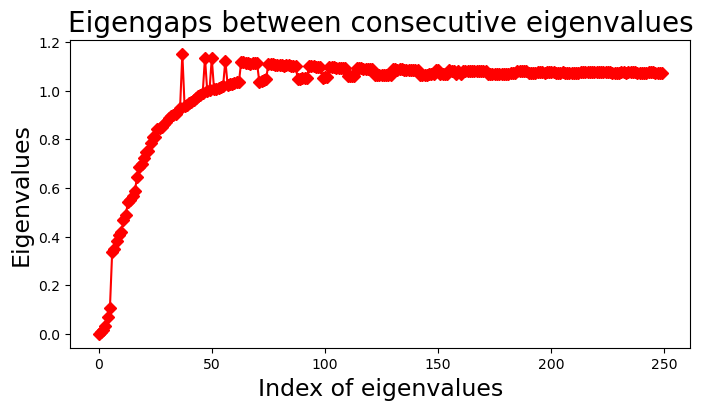

In [10]:
aff = affinity_matrix(X, k=14)
n_clus = eigengap_heuristic(aff)
print('Optimal number of clusters:', n_clus)